In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542087 sha256=56f6e9eac8153b9bcb14457421a3ae73bd64d3bea7b5419e7823ea036c01ea66
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


In [3]:
import numpy as np
import pandas as pd

In [4]:

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.metrics import specificity_score # specificity_score 임포트
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten
import seaborn as sns
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import random
import numpy as np

In [5]:
# 1. 데이터 로드
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample100.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample100.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_original.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_original.csv')


X_train = df_X_train.values
y_train = df_y_train.values.reshape(-1)  # 1차원 배열(벡터)로 변환
X_test = df_X_test.values
y_test = df_y_test.values.reshape(-1)  # 1차원 배열(벡터)로 변환


In [6]:
# 소수 클래스와 다수 클래스 식별
target_counts = pd.Series(y_train).value_counts()
minority_class = target_counts.idxmin()
majority_class = target_counts.idxmax()

# 소수 클래스 샘플 추출
X_minority = X_train[y_train == minority_class]
X_major = X_train[y_train == majority_class]

In [7]:
def t_smote_augmentation(X_minority, X_major, k=5, alpha_range=(0.2, 0.8), seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    n_synthetic = len(X_major) - len(X_minority)
    synthetic_samples = []

    # 1. 각 시계열에 대해 K개의 DTW 기반 이웃 찾기
    neighbor_dict = find_k_nearest_neighbors_dtw(X_minority, k)

    # 2. 증강 데이터 생성
    for _ in range(n_synthetic):
        # 소수 클래스 샘플 중 하나 선택
        idx_a = random.randint(0, len(X_minority) - 1)
        A = X_minority[idx_a]

        # 그 이웃 중 하나를 랜덤 선택
        neighbors = neighbor_dict[idx_a]
        idx_b = random.choice(neighbors)
        B = X_minority[idx_b]

        # α 값 설정
        alpha = random.uniform(*alpha_range)

        # 시계열 선형 보간 (A와 B는 동일 길이여야 함)
        S = alpha * A + (1 - alpha) * B

        synthetic_samples.append(S)

    return np.array(synthetic_samples)


In [8]:
def find_k_nearest_neighbors_dtw(X_minority, k):
    n_samples = len(X_minority)
    neighbors_dict = {}

    for i in range(n_samples):
        distances = []
        A = np.array(X_minority[i]).flatten()

        for j in range(n_samples):
            if i == j:
                continue
            B = np.array(X_minority[j]).flatten()
            dist, _ = fastdtw(A, B)
            distances.append((j, dist))

        # 거리 기준 정렬 후 상위 k개 선택
        distances.sort(key=lambda x: x[1])
        neighbors_dict[i] = [idx for idx, _ in distances[:k]]

    return neighbors_dict


In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

def find_optimal_k(X_minority, X_major, y_train, k_range=(3, 11), k_step=2, model=None, n_synthetic=None):

    best_k = None
    best_score = -np.inf

    # n_synthetic 값을 X_major, X_minority로 자동 설정
    if n_synthetic is None:
        n_synthetic = len(X_major) - len(X_minority)

    # k 값 범위 설정
    k_values = range(k_range[0], k_range[1], k_step)

    # 각 k 값에 대해 성능 평가
    for k in k_values:
        print(f"Evaluating k={k}...")

        # T-SMOTE 합성 데이터 생성
        synthetic_X = t_smote_augmentation(X_minority, X_major, k=k)

        # 합성 데이터를 포함한 전체 데이터셋 준비
        X_train_augmented = np.vstack([X_train, synthetic_X])
        y_synthetic = np.full(len(synthetic_X), minority_class)
        y_train_augmented = np.concatenate([y_train, y_synthetic])

        # 교차 검증
        if model is None:
            model = RandomForestClassifier()

        # 5-fold 교차 검증을 통해 평가 (예시: 정확도)
        score = np.mean(cross_val_score(model, X_train_augmented, y_train_augmented, cv=5, scoring='accuracy'))

        # 성능이 가장 좋은 k 선택
        if score > best_score:
            best_score = score
            best_k = k

    return best_k
optimal_k = find_optimal_k(X_minority, X_major, y_train, k_range=(3, 11), k_step=2, model=RandomForestClassifier())
print(f"최적의 k 값은: {optimal_k}")

Evaluating k=3...
Evaluating k=5...
Evaluating k=7...
Evaluating k=9...
최적의 k 값은: 3


In [10]:
synthetic_X = t_smote_augmentation(X_minority, X_major, k=optimal_k, seed=42)
X_train_augmented = np.vstack([X_train, synthetic_X])
y_synthetic = np.full(len(synthetic_X), minority_class)
y_train_augmented = np.concatenate([y_train, y_synthetic])

In [11]:
print(len(synthetic_X))
print(len(X_train_augmented))
print(len(y_synthetic))
print(len(y_train_augmented))

1110
2344
1110
2344


In [12]:
def predict_with_logistic_regression(X_train, y_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_cart(X_train, y_train, X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_knn(X_train, y_train, X_test, k=3):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_xgboost(X_train, y_train, X_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_lstm(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

def predict_with_cnn(X_train, y_train, X_test):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:41:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(*

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Logistic Regression 모델 성능:
정확도: 0.6329, F1: 0.7102, Recall: 0.7338, Specificity: 0.4729
Confusion Matrix:
[[157 175]
 [140 386]]


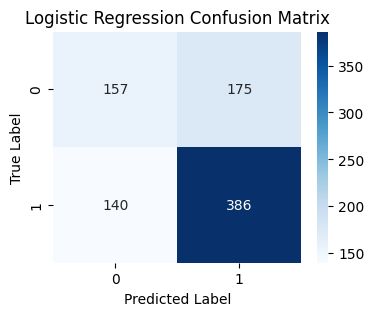

CART 모델 성능:
정확도: 0.6562, F1: 0.7584, Recall: 0.8802, Specificity: 0.3012
Confusion Matrix:
[[100 232]
 [ 63 463]]


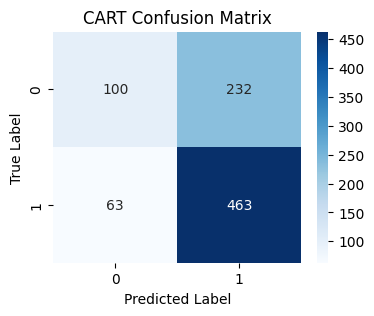

KNN 모델 성능:
정확도: 0.6993, F1: 0.7784, Recall: 0.8612, Specificity: 0.4428
Confusion Matrix:
[[147 185]
 [ 73 453]]


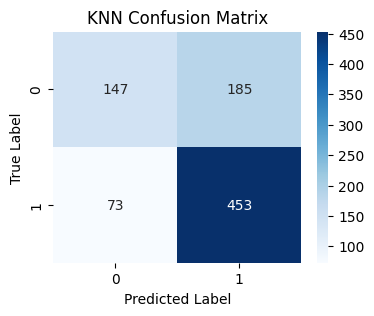

XGBoost 모델 성능:
정확도: 0.6783, F1: 0.7867, Recall: 0.9677, Specificity: 0.2199
Confusion Matrix:
[[ 73 259]
 [ 17 509]]


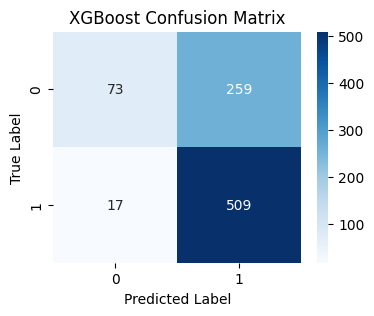

LSTM 모델 성능:
정확도: 0.6503, F1: 0.7070, Recall: 0.6882, Specificity: 0.5904
Confusion Matrix:
[[196 136]
 [164 362]]


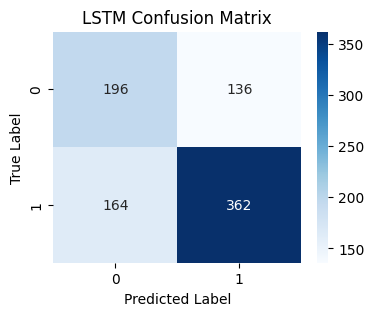

CNN 모델 성능:
정확도: 0.6026, F1: 0.6566, Recall: 0.6198, Specificity: 0.5753
Confusion Matrix:
[[191 141]
 [200 326]]


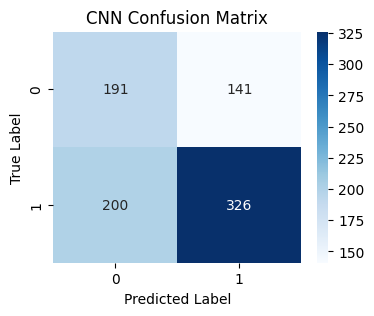

In [13]:
# 예측 실행 및 평가
predictions = {
    "Logistic Regression": predict_with_logistic_regression(X_train_augmented, y_train_augmented, X_test),
    "CART": predict_with_cart(X_train_augmented, y_train_augmented, X_test),
    "KNN": predict_with_knn(X_train_augmented, y_train_augmented, X_test),
    "XGBoost": predict_with_xgboost(X_train_augmented, y_train_augmented, X_test),
    "LSTM": predict_with_lstm(X_train_augmented, y_train_augmented, X_test),
    "CNN": predict_with_cnn(X_train_augmented, y_train_augmented, X_test)
}
# 성능 지표 저장을 위한 리스트
results = []
for model_name, pred_y in predictions.items():
    accuracy = accuracy_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y)
    specificity = specificity_score(y_test, pred_y)
    conf_matrix = confusion_matrix(y_test, pred_y)
    results.append([accuracy, f1, recall, specificity, conf_matrix])
    print(f"{model_name} 모델 성능:")
    print(f"정확도: {accuracy:.4f}, F1: {f1:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


In [14]:
# 성능 지표를 DataFrame으로 변환
results_df = pd.DataFrame(results, columns=["Accuracy", "F1", "Recall", "Specificity", "Confusion Matrix"], index=predictions.keys())
model_results = results_df.T
# 결과를 출력
print("\n모델 성능 비교 결과:")
print(model_results)

# 결과를 CSV 파일로 저장
model_results.to_csv("/content/drive/My Drive/PhalangesOutlinesCorrect/results/tsmote_models_result.csv")


모델 성능 비교 결과:
                       Logistic Regression                     CART  \
Accuracy                          0.632867                 0.656177   
F1                                0.710212                 0.758395   
Recall                             0.73384                 0.880228   
Specificity                       0.472892                 0.301205   
Confusion Matrix  [[157, 175], [140, 386]]  [[100, 232], [63, 463]]   

                                      KNN                 XGBoost  \
Accuracy                         0.699301                0.678322   
F1                               0.778351                0.786708   
Recall                           0.861217                0.967681   
Specificity                      0.442771                 0.21988   
Confusion Matrix  [[147, 185], [73, 453]]  [[73, 259], [17, 509]]   

                                      LSTM                       CNN  
Accuracy                           0.65035                  0.602564  
F1